In [1]:
# Run in python console
import nltk

import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt


# Enable logging for gensim - optional
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

#nltk.download('stopwords')
# nltk.download('punkt') 
# nltk.download('averaged_perceptron_tagger')

# NLTK Stop words
from nltk.corpus import stopwords

C:\Users\KYH\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [35]:
#불용단어 준비
stop_words = stopwords.words('english')
stop_words.extend(['http','https','make','captain','trailer','theater','ticket','studio','marvel','captainmarvel','good','www','review','bad','weekend','galaxy','avengers','war','marvel','watch','movie','get','time','film','see','new','avenger','go','office','box','infinity']) #여기는 우리가 불용단어 추가하면 된다.
# print(stop_words)

In [16]:
# Import Dataset
def to_table(filename):
    with open(filename, 'r',encoding='UTF8') as apple:
        a = []
        for apps in apple.readlines():
            b = (apps.strip())
            b = b.strip('.,?!;-')
            a.append(b)
            line_list = []
            for line in a:
                line = line.strip('.,?!;-')
                line_list += line.split()
    return line_list

df = to_table('captain marvel twitter.txt')
# print(df)

['Exclusive:', 'The', 'Mighty', 'Bursts', 'Onto', 'the', 'Scene', 'w/Video', 'Series', '&', 'Music', 'From', 'Glass', 'Candy', "They're", 'back.', 'Watch', 'the', 'extended', 'Big', 'Game', 'spot...', 'obviously', 'Action...', "Here's", 'your', 'first', 'look', 'at', 'the', 'teaser', 'poster', 'for', 'Marvel', 'Studios’', ',', 'in', 'theaters', 'March', '8,', '2019', 'soars', 'into', 'the', 'Cinematic', 'Universe', 'HERO.', 'LEGEND.', 'KING.', 'Watch', 'the', 'teaser', 'trailer', 'now', 'OFFICIAL:', 'Nicole', 'Perlman', '&', 'Meg', 'LeFauve', 'to', 'co-write', ',', 'coming', 'November', '2,', '2018', 'Happy', 'to', 'this', 'amazing', 'hero', "'Tis", 'the', 'season', 'for', 'gingerbread', 'cookies', '—', 'Marvel-style', 'ǝƃuɐɹʇSɹoʇɔop#', '¿uʍop', 'ǝpᴉsdn', 'pǝuɹnʇ', 'plɹoʍ', 'ɹnoʎ', 'ǝʌɐɥ', 'oʇ', 'ʎpɐǝɹ', 'noʎ', 'ǝɹ∀', 'I', 'did', 'a', 'variant', 'for', 'Captain', 'Marvel', '#3', 'with', 'Marvel', 'Studios', 'kicks', 'off', 'its', 'yearlong', '10th', 'anniversary', 'celebration', 'with'

In [17]:
tmp = []
for i in df:
    i = i.strip('.,?!;-').lower()
    texts = nltk.word_tokenize(i)
    tmp += nltk.pos_tag(texts)

# print(tmp)

In [6]:
# http://sens.tistory.com/454 참조, 형태소따라 나누기
def pos_extractor(parsed):

    noun_list = []
    adj_list = []
    verb_list = []
    nav_list = []
    adv_list = []

    for i in parsed:

        if i[1] in ['NN', 'NNS', 'NNP', 'NNPS']:
            noun_list.append(i[0])
            nav_list.append(i[0])
        elif i[1] in ['JJ', 'JJR', 'JJS']:
            adj_list.append(i[0])
            nav_list.append(i[0])
        elif i[1] in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
            verb_list.append(i[0])
            nav_list.append(i[0])
        elif i[1] == ['RB', 'RBR', 'RBS']:
            adv_list.append(i[0])
            nav_list.append(i[0])

        else:
            pass

    return [nav_list, noun_list, adj_list,
            verb_list]  

In [26]:
# print(pos_extractor(tmp))

data_words = list(pos_extractor(tmp)[0])
print(data_words)

['exclusive', 'mighty', 'bursts', 'scene', 'w/video', 'series', 'music', 'glass', 'candy', "'re", 'watch', 'extended', 'big', 'game', 'spot', 'action', 'look', 'teaser', 'poster', 'marvel', 'studios', '’', 'theaters', 'march', 'soars', 'cinematic', 'universe', 'hero', 'legend', 'king', 'watch', 'teaser', 'trailer', 'official', 'nicole', 'perlman', 'meg', 'lefauve', 'co-write', 'coming', 'november', 'happy', 'amazing', 'hero', 'is', 'season', 'gingerbread', 'cookies', '—', 'marvel-style', '¿uʍop', 'ǝpᴉsdn', 'pǝuɹnʇ', 'plɹoʍ', 'ɹnoʎ', 'ǝʌɐɥ', 'oʇ', 'ʎpɐǝɹ', 'noʎ', 'ǝɹ∀', 'i', 'did', 'variant', 'captain', 'marvel', 'marvel', 'studios', 'kicks', '10th', 'anniversary', 'celebration', 'behind-the-scenes', 'look', 'class', 'photo', 'featuring', 'actors', 'filmmakers', 'marvel', 'cinematic', 'universe', 'get', 'speed', 'mighty', 'captain', 'marvel', 'new', 'video', 'featuring', 'music', 'live', 'king', 'watch', 'new', 'trailer', 'marvel', 'studios', 'theaters', 'february', 'special', 'message'

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)  # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# print(data_words)
# print(trigram_mod[bigram_mod[data_words]])

In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]


def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]


def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [36]:
data_words_nostops = remove_stopwords(data_words)

In [37]:
# Form Bigrams
# data_words_bigrams = make_bigrams(data_words_nostops)
data_words_trigrams=make_trigrams(data_words_nostops)
# print(data_words_trigrams)

[['exclusive'], ['mighty'], ['bursts'], ['scene'], ['video'], ['series'], ['music'], ['glass'], ['candy'], [], [], ['extended'], ['big'], ['game'], ['spot'], ['action'], ['look'], ['teaser'], ['poster'], [], ['studios'], [], ['theaters'], ['march'], ['soars'], ['cinematic'], ['universe'], ['hero'], ['legend'], ['king'], [], ['teaser'], [], ['official'], ['nicole'], ['perlman'], ['meg'], ['lefauve'], ['co', 'write'], ['coming'], ['november'], ['happy'], ['amazing'], ['hero'], [], ['season'], ['gingerbread'], ['cookies'], [], ['style'], ['uʍop'], ['ǝpᴉsdn'], ['pǝuɹnʇ'], ['plɹoʍ'], ['ɹnoʎ'], ['ǝʌɐɥ'], ['oʇ'], ['ʎpɐǝɹ'], ['noʎ'], ['ǝɹ'], [], [], ['variant'], [], [], [], ['studios'], ['kicks'], ['th'], ['anniversary'], ['celebration'], ['behind', 'scenes'], ['look'], ['class'], ['photo'], ['featuring'], ['actors'], ['filmmakers'], [], ['cinematic'], ['universe'], [], ['speed'], ['mighty'], [], [], [], ['video'], ['featuring'], ['music'], ['live'], ['king'], [], [], [], [], ['studios'], ['th

In [20]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en (cmd에서 실행)
nlp = spacy.load('en', disable=['parser', 'ner'])

In [38]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# print(data_lemmatized)
# Remove Stop Words
data_lemmatized2 = remove_stopwords(data_lemmatized)
# print(data_lemmatized2)

In [39]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized2)
# print(id2word)

# Create Corpus
texts = data_lemmatized2
for i in texts:
    try:
        i == [] or ['\n']
        texts.remove(i)
    except IndexError:
        pass

list_a = []

for i in texts:
    try:
        list_a.append(i[0])
    except IndexError:
        pass

In [40]:
# Term Document Frequency
corpus = [id2word.doc2bow(list_a) for text in texts]
# print(corpus)
# print(corpus[2]) # 일부가 출력되었음
 
# Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

In [50]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
id2word=id2word,
num_topics=2,
random_state=100,
update_every=1,
chunksize=100,
passes=10,
alpha='auto',
per_word_topics=True)

In [51]:
# Print the Keyword in the 10 topics
# carol과 brie는 주인공 이름입니다.
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.020*"brand" + 0.019*"fan" + 0.018*"game" + 0.017*"hero" + 0.016*"teaser" '
  '+ 0.015*"photo" + 0.015*"arrive" + 0.015*"tune" + 0.014*"cinematic" + '
  '0.014*"live"'),
 (1,
  '0.022*"hero" + 0.021*"game" + 0.020*"fan" + 0.019*"brand" + 0.016*"trip" + '
  '0.015*"king" + 0.015*"exclusive" + 0.014*"chance" + 0.013*"update" + '
  '0.013*"available"')]


In [18]:
# Compute Perplexity(모델 난이도)
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) # a measure of how good the model is. lower the better.


Perplexity:  -7.0470954998314355


In [19]:
# Compute Coherence Score(일관성 점수)
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.8518736892580371


In [52]:
# Visualize the topics(대화형차트) - 토픽과 키워드 검사
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x    y
topic                                           
0      54.589836        1       1  0.003946  0.0
1      45.410164        1       2 -0.003946  0.0, topic_info=     Category        Freq         Term       Total  loglift  logprob
term                                                                
66    Default  491.000000         trip  491.000000  30.0000  30.0000
48    Default  246.000000  celebration  246.000000  29.0000  29.0000
21    Default  737.000000         hero  737.000000  28.0000  28.0000
117   Default  246.000000          dip  246.000000  27.0000  27.0000
218   Default  246.000000     favorite  246.000000  26.0000  26.0000
23    Default  491.000000         king  491.000000  25.0000  25.0000
26    Default  246.000000      perlman  246.000000  24.0000  24.0000
112   Default  246.000000        event  246.000000  23.0000  23.0000
134   Default  246.000000      thewasp  246.000000  22.0000  22.0000
11    Default  737.000000         game  737.000000  21.0000  21.0000
204   Default  246.000000          air  246.000000  20.0000  20.0000
0     Default  491.000000    exclusive  491.000000  19.0000  19.0000
61    Default  246.000000        enter  246.000000  18.0000  18.0000
49    Default  246.000000        class  246.000000  17.0000  17.0000
43    Default  246.000000         ǝʌɐɥ  246.000000  16.0000  16.0000
187   Default  246.000000          bit  246.000000  15.0000  15.0000
229   Default  246.000000     tomorrow  246.000000  14.0000  14.0000
38    Default  246.000000        style  246.000000  13.0000  13.0000
86    Default  246.000000      warrior  246.000000  12.0000  12.0000
228   Default  246.000000         call  246.000000  11.0000  11.0000
131   Default  246.000000       actual  246.000000  10.0000  10.0000
125   Default  246.000000         jude  246.000000   9.0000   9.0000
63    Default  246.000000   sweepstake  246.000000   8.0000   8.0000
64    Default  491.000000       chance  491.000000   7.0000   7.0000
22    Default  246.000000       legend  246.000000   6.0000   6.0000
15    Default  491.000000       teaser  491.000000   5.0000   5.0000
189   Default  246.000000        learn  246.000000   4.0000   4.0000
59    Default  737.000000          fan  737.000000   3.0000   3.0000
195   Default  246.000000      receive  246.000000   2.0000   2.0000
100   Default  246.000000        bring  246.000000   1.0000   1.0000
...       ...         ...          ...         ...      ...      ...
131    Topic2  129.339645       actual  246.476471   0.1446  -4.8814
63     Topic2  128.516388   sweepstake  246.476425   0.1382  -4.8878
22     Topic2  128.112183       legend  246.476471   0.1351  -4.8909
21     Topic2  380.901947         hero  737.441650   0.1288  -3.8013
189    Topic2  126.215607        learn  246.476593   0.1202  -4.9058
195    Topic2  125.331627      receive  246.476578   0.1131  -4.9129
100    Topic2  125.171173        bring  246.476593   0.1118  -4.9142
4      Topic2  125.144661        video  246.476624   0.1116  -4.9144
206    Topic2  125.092812         base  246.476593   0.1112  -4.9148
190    Topic2  125.075958       follow  246.476608   0.1111  -4.9149
0      Topic2  249.326736    exclusive  491.959351   0.1098  -4.2251
136    Topic2  124.876633       carpet  246.476593   0.1095  -4.9165
46     Topic2  124.487152         kick  246.476593   0.1064  -4.9196
110    Topic2  123.464684         year  246.476562   0.0981  -4.9279
11     Topic2  364.813599         game  737.442139   0.0856  -3.8444
64     Topic2  240.107147       chance  491.959534   0.0721  -4.2627
59     Topic2  344.722809          fan  737.442688   0.0290  -3.9011
223    Topic2  229.116440       update  491.959839   0.0253  -4.3096
122    Topic2  321.955811        brand  737.443359  -0.0393  -3.9694
78     Topic2  226.796509    available  491.959930   0.0151  -4.3198
1      Topic2  224.039383       mighty  491.959900   0.0029  -4.3320
92     Topic2  217.041351        ca

In [21]:
# Show Topics
pprint(lda_model.show_topics(formatted=False))

[(6,
  [('trailer', 0.019938346),
   ('woman', 0.010300504),
   ('carol', 0.009199812),
   ('brie', 0.008698754),
   ('smile', 0.008009472),
   ('man', 0.007930054),
   ('mcu', 0.007857103),
   ('people', 0.006883877),
   ('know', 0.0057797115),
   ('look', 0.005628144)]),
 (14,
  [('trailer', 0.014390909),
   ('woman', 0.012413803),
   ('smile', 0.009007018),
   ('larson', 0.0085503785),
   ('man', 0.008435695),
   ('look', 0.008291909),
   ('mcu', 0.008228432),
   ('brie', 0.007191799),
   ('spider', 0.006527868),
   ('carol', 0.0063669244)]),
 (7,
  [('trailer', 0.025733186),
   ('woman', 0.009063315),
   ('man', 0.007868489),
   ('look', 0.0076595554),
   ('know', 0.0076285754),
   ('carol', 0.0071505974),
   ('brie', 0.007028966),
   ('larson', 0.006657208),
   ('mcu', 0.0066474313),
   ('hero', 0.006467627)]),
 (4,
  [('trailer', 0.017571386),
   ('woman', 0.009617943),
   ('smile', 0.009273735),
   ('brie', 0.008839297),
   ('carol', 0.007821099),
   ('mcu', 0.0074589346),
   ('

In [43]:
# k의 수(최적의 토픽 수) 를 찾아보기 
#밑의 함수는 여러 LDA 모델을 교육하고 모델 및 해당하는 일관성 점수를 알려준다.
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics
 
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
 
    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=num_topics,random_state=100,
                                              update_every=1,chunksize=100,passes=10,alpha='auto',per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
 
    return model_list, coherence_values

In [44]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=20, step=3)

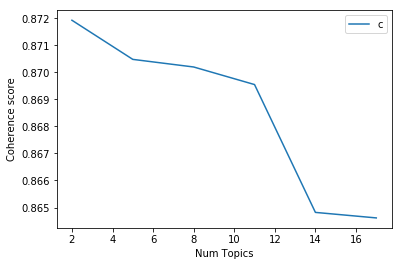

In [45]:
# Show graph
limit=20; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [46]:
# Print the coherence scores 가장 일관성 높은 모델 선택
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.8719
Num Topics = 5  has Coherence Value of 0.8705
Num Topics = 8  has Coherence Value of 0.8702
Num Topics = 11  has Coherence Value of 0.8695
Num Topics = 14  has Coherence Value of 0.8648
Num Topics = 17  has Coherence Value of 0.8646


In [47]:
# Select the model and print the topics
optimal_model = model_list[0] #여긴 경우에 따라 고치기
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.020*"brand" + 0.019*"fan" + 0.018*"game" + 0.017*"hero" + 0.016*"teaser" '
  '+ 0.015*"photo" + 0.015*"arrive" + 0.015*"tune" + 0.014*"cinematic" + '
  '0.014*"live"'),
 (1,
  '0.022*"hero" + 0.021*"game" + 0.020*"fan" + 0.019*"brand" + 0.016*"trip" + '
  '0.015*"king" + 0.015*"exclusive" + 0.014*"chance" + 0.013*"update" + '
  '0.013*"available"')]


In [49]:
## mallet

# mallet_path = 'C:/temp/mallet-2.0.8/bin/mallet' # update this path
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)
# pprint(ldamallet.show_topics(formatted=False))
 
# Compute Coherence Score
# coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
# coherence_ldamallet = coherence_model_ldamallet.get_coherence()
# print('\nCoherence Score: ', coherence_ldamallet)